### Capstone Project - The Battle of Neighborhoods

#### Introduction/Business Problem 

With the huge amount of data and feedbacks in Foursquare, as well as the geographic information of NYC and Toronto, I am curious about the following questions:

1. We all know both NYC and Toronto are big multicultural cities, but is there any difference of taste in the these 2 cities? What are the most favored and least favored styles of food in NYC and Toronto? Are the preferences of food consistent with their race/immigrants (original) nationality compostion?

2. As social network apps are more and more popular nowadays, the feedbacks on apps like Foursquare, Yelp, etc are more and more important to restaurants. Higher rating, more comments and more facny photos are great help to promote a restauarant and attract more customers. I would like find out what kind of resturants have the highest ratings, the most comments and the most photos. In addition, I want to find out do more feedbacks (comments and photos) imply extremer (high or low) ratings.

3. Cluster the neighborhoods by the amount of feedbacks. Currently, I assume restaurants in businees areas will have less feedbacks. Because people go there either just grab something to eat during breaks or have business dinners, they do not have time/mood to take pictures and leave comments or it's inappropriate to do so in a business dinner. On the other hand, restaurants in leisure/fun/living areas may have more feedbacks, because people usually go there with family and friends and they like taking pictures and commenting on the foods/atomphere under such scenario. I do not live either city and I do not know too much about them, yet I am relatively more familiar with NYC, so I will only study NYC for this item.

#### I.Data

1. Most of the data are available in Foursquare, but need to write new codes to pull them (i.e. ratings, photos, comments).
2. Geographic data is available from previous projects.
2. Need to find the race/immigrants (original) nationality compostion for these 2 cities.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm

import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.12.5          |   py36h5fab9bb_1         143 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         240 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0

The following packages will be UPDATED:

  certifi                          2020.12.5-py36h5fab9bb_0 --> 2020.12.5-py36h5fab9bb_1



geopy-2.1.0          | 64 KB     

In [2]:
!pip3 install lxml
!pip install lxml
#import lxml

     |████████████████████████████████| 5.4 MB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 5.8MB/s eta 0:00:01


##### A. Get Geo information for NYC and Toronto

##### a. NYC Geo data

In [3]:
# use NYC geo data and code from previous NYC project
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
# Notice how all the relevant data is in the features key, which is basically a list of the neighborhoods. So, define a new variable that includes this data.    
neighborhoods_data = newyork_data['features']    

# transforming this data of nested Python dictionaries into a pandas dataframe.
# start by creating an empty dataframe.
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_nyc = pd.DataFrame(columns=column_names)

# Then loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_nyc = neighborhoods_nyc.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print(neighborhoods_nyc.shape)
neighborhoods_nyc.head()

Data downloaded!
(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


##### b. Toronto Geo data

In [4]:
!pip3 install pgeocode
!pip install pgeocode
import pgeocode # import geocoder

ca_1=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
# drop rows with Borough ='Not assigned'
ca_2=ca_1[ca_1['Borough'] != 'Not assigned'].reset_index(drop=True)

# If a cell has a borough but a neighborhood = 'Not assigned', then neighborhood = borough
# since we have dropped borough = 'Not assigned' in ca_2 table, we can just locate neighorhood = 'Not assigned' and replce it with borough
ca_2.loc[ca_2['Neighbourhood'] == 'Not assigned', 'Neighbourhood_replaced']=ca_2['Borough']
ca_2.loc[ca_2['Neighbourhood'] != 'Not assigned', 'Neighbourhood_replaced']=ca_2['Neighbourhood']
ca_2=ca_2.drop(['Neighbourhood'], axis=1)
ca_2.rename(columns={'Neighbourhood_replaced':'Neighborhood'}, inplace=True)
# get lat and lon coordinates
nomi=pgeocode.Nominatim('ca')
for i in range(len(ca_2)):
    ca_2.loc[i,'Latitude'] = nomi.query_postal_code('{}'. format(ca_2.loc[i,'Postal Code'])).latitude
    ca_2.loc[i,'Longitude'] = nomi.query_postal_code('{}'.format(ca_2.loc[i,'Postal Code'])).longitude

# filter the Boroughs contain 'Toronto'
ca_3=ca_2[ca_2['Borough'].str.contains('Toronto')].reset_index(drop=True)

neighborhoods_toronto=ca_3.drop(['Postal Code'], axis=1)
print(neighborhoods_toronto.shape)
neighborhoods_toronto.head()

     |████████████████████████████████| 15.4 MB 58 kB/s  eta 0:00:01     |███████                         | 3.3 MB 10.1 MB/s eta 0:00:02     |███████████▊                    | 5.6 MB 10.1 MB/s eta 0:00:01     |████████████████████████▌       | 11.7 MB 5.3 MB/s eta 0:00:01     |████████████████████████████▉   | 13.8 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 5.4 MB/s eta 0:00:011
     |████████████████████████████████| 510 kB 23.3 MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/35/88/688b8550ceeed59a4b0be3f54d2ad8075ce708b5d5c0b0ec1a3abe58d4cb/pgeocode-0.3.0-py3-none-any.whl
(39, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889
2,Downtown Toronto,"Garden District, Ryerson",43.6572,-79.3783
3,Downtown Toronto,St. James Town,43.6513,-79.3756
4,East Toronto,The Beaches,43.6784,-79.2941


##### c. Get venue names in NYC and Toronto in each borough/neigborhood

In [5]:
CLIENT_ID = 'GPEVTUHCEN21MHG1TEH3AGA25LIH2GOPGUK30E25S2YVDJ3X' # your Foursquare ID
CLIENT_SECRET = '3KRVQXI4NE5Y3EJXPAGXXB5JLRBGUYFJ5JD30Y5FWMNO0O3L' # your Foursquare Secret
ACCESS_TOKEN = 'QPUQJ2GRNQYIRGQFSL1EZCOJGGYM1WNS4QBX5MDKOOBFPKPT' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: GPEVTUHCEN21MHG1TEH3AGA25LIH2GOPGUK30E25S2YVDJ3X
CLIENT_SECRET:3KRVQXI4NE5Y3EJXPAGXXB5JLRBGUYFJ5JD30Y5FWMNO0O3L


In [6]:
def getNearbyVenues(boroughs,names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for borough, name, lat, lng in zip(boroughs, names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'ID']
    
    return(nearby_venues)

In [7]:
# Get NYC venues
venues_nyc = getNearbyVenues(boroughs=neighborhoods_nyc['Borough'], names=neighborhoods_nyc['Neighborhood'], latitudes=neighborhoods_nyc['Latitude'], longitudes=neighborhoods_nyc['Longitude'])
print(venues_nyc.shape)
venues_nyc.head(10)

(10047, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,ID
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,4c537892fd2ea593cb077a28
1,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,4c783cef3badb1f7e4244b54
2,Bronx,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,5d5f5044d0ae1c0008f043c3
3,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,4d6af9426107f04dedeb297a
4,Bronx,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,4c25c212f1272d7f836385c5
5,Bronx,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant,508af256e4b0578944c87392
6,Bronx,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place,4d33665fb6093704b80001e0
7,Bronx,Wakefield,40.894705,-73.847201,Pitman Deli,40.896744,-73.844398,Food,4e440828a809d4ed1bb7059f
8,Bronx,Wakefield,40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,Laundromat,5681717c498e9b9cf4d8c187
9,Bronx,Co-op City,40.874294,-73.829939,Capri II Pizza,40.876374,-73.829940,Pizza Place,4d2cfa5cad25224bbbc5fb8f


In [8]:
# Get Toronto venues
venues_toronto = getNearbyVenues(boroughs=neighborhoods_toronto['Borough'], names=neighborhoods_toronto['Neighborhood'], latitudes=neighborhoods_toronto['Latitude'], longitudes=neighborhoods_toronto['Longitude'])
print(venues_toronto.shape)
venues_toronto.head(10)

(1521, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,ID
0,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Tandem Coffee,43.653559,-79.361809,Coffee Shop,53b8466a498e83df908c3f21
1,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Roselle Desserts,43.653447,-79.362017,Bakery,54ea41ad498e9a11e9e13308
2,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot,4af59046f964a520e0f921e3
3,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,The Yoga Lounge,43.655515,-79.364955,Yoga Studio,4b58dd55f964a5208f6f28e3
4,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Body Blitz Spa East,43.654735,-79.359874,Spa,50760559e4b0e8c7babe2497
5,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Sumach Espresso,43.658135,-79.359515,Coffee Shop,5619551a498e9e35fce2256b
6,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Dominion Pub and Kitchen,43.656919,-79.358967,Pub,566e1294498e3f6629006bc3
7,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot,4ae5b91ff964a520a6a121e3
8,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Berkeley Church,43.655123,-79.365873,Event Space,4ade8ea8f964a5205a7621e3
9,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Sukhothai,43.658444,-79.365681,Thai Restaurant,4ada57aff964a520972121e3


##### d. Fliter the venue category for restaurants

In [9]:
# check the venue categories in NYC and Toronto. Filter for food/restaurants
# NYC
venue_category_nyc=venues_nyc['Venue Category'].unique().tolist()
venue_category_nyc.sort()
print (venue_category_nyc)

['ATM', 'Accessories Store', 'Adult Boutique', 'Afghan Restaurant', 'African Restaurant', 'Airport Terminal', 'American Restaurant', 'Antique Shop', 'Arcade', 'Arepa Restaurant', 'Argentinian Restaurant', 'Art Gallery', 'Art Museum', 'Arts & Crafts Store', 'Arts & Entertainment', 'Asian Restaurant', 'Athletics & Sports', 'Auditorium', 'Australian Restaurant', 'Austrian Restaurant', 'Auto Garage', 'Auto Workshop', 'Automotive Shop', 'BBQ Joint', 'Baby Store', 'Bagel Shop', 'Bakery', 'Bank', 'Bar', 'Baseball Field', 'Baseball Stadium', 'Basketball Court', 'Bath House', 'Beach', 'Beach Bar', 'Bed & Breakfast', 'Beer Bar', 'Beer Garden', 'Beer Store', 'Big Box Store', 'Bike Rental / Bike Share', 'Bike Shop', 'Bike Trail', 'Bistro', 'Board Shop', 'Boarding House', 'Boat or Ferry', 'Bookstore', 'Border Crossing', 'Boutique', 'Bowling Alley', 'Boxing Gym', 'Brazilian Restaurant', 'Breakfast Spot', 'Brewery', 'Bridal Shop', 'Bridge', 'Bubble Tea Shop', 'Buffet', 'Building', 'Burger Joint', 'Bu

In [10]:
# Since cafe, deli, bakery, bar, ice cream are pretty common in the US and Canada, it's not worth to include them.
# I filter the category "X Restaurant",  so that I can find out what kind of food are popular
venues_nyc_restaurants=venues_nyc[venues_nyc['Venue Category'].str.contains(' Restaurant')].reset_index(drop=True)
print(venues_nyc_restaurants.shape)
venues_nyc_restaurants.head(20)

(2399, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,ID
0,Bronx,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant,508af256e4b0578944c87392
1,Bronx,Co-op City,40.874294,-73.829939,Arby's,40.870411,-73.828606,Fast Food Restaurant,5bc797c82d2fd9002c1b3ec6
2,Bronx,Eastchester,40.887556,-73.827806,Fish & Ting,40.885656,-73.829197,Caribbean Restaurant,515cc20ce4b0deb133b8e89b
3,Bronx,Eastchester,40.887556,-73.827806,Dyre Fish Market,40.889318,-73.831453,Seafood Restaurant,4bfdd3dfb68d0f47fa6fe957
4,Bronx,Eastchester,40.887556,-73.827806,Golden Krust Caribbean Restaurant,40.888488,-73.831083,Caribbean Restaurant,4c632fbaeb82d13a3c5007d6
5,Bronx,Eastchester,40.887556,-73.827806,Xing Lung Chinese Restaurant,40.888785,-73.831226,Chinese Restaurant,4dabc3dc93a04642f09ccabd
6,Bronx,Eastchester,40.887556,-73.827806,Royal Caribbean Bakery,40.888249,-73.831661,Caribbean Restaurant,4dbf84a24df0f8fd6b88c9b6
7,Bronx,Eastchester,40.887556,-73.827806,McDonald's,40.885636,-73.826840,Fast Food Restaurant,4c406f2e6c1a9521a042b96a
8,Bronx,Kingsbridge,40.881687,-73.902818,Leche y Miel,40.883742,-73.901857,Latin American Restaurant,55297008498e9286460da191
9,Bronx,Kingsbridge,40.881687,-73.902818,El Malecon,40.879338,-73.904457,Caribbean Restaurant,4bd8e98811dcc928f865f833


In [11]:
# Toronto
venues_toronto_restaurants=venues_toronto[venues_toronto['Venue Category'].str.contains(' Restaurant')].reset_index(drop=True)
print(venues_toronto_restaurants.shape)
venues_toronto_restaurants.head(20)

(342, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,ID
0,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Sukhothai,43.658444,-79.365681,Thai Restaurant,4ada57aff964a520972121e3
1,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Mangia and Bevi Resto-Bar,43.652250,-79.366355,Italian Restaurant,4ad776eef964a520e20a21e3
2,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Tokyo Sushi,43.665885,-79.386977,Sushi Restaurant,4afca145f964a5208e2422e3
3,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Como En Casa,43.665160,-79.384796,Mexican Restaurant,4fb593c0e4b05a76e2ab2951
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Nando's,43.661728,-79.386391,Portuguese Restaurant,52d884c5498ecf5c7cafe5ab
5,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Sansotei Ramen 三草亭,43.666735,-79.385353,Ramen Restaurant,534c20fa498ee7bc010834ce
6,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Sushi Garden,43.664858,-79.384941,Sushi Restaurant,4ba6b463f964a520416a39e3
7,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Tokyo Grill,43.665085,-79.384707,Japanese Restaurant,4ad4c061f964a520abf720e3
8,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Ethiopian House,43.666599,-79.385669,Ethiopian Restaurant,4a72360ef964a52098da1fe3
9,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Mercatto,43.660391,-79.387664,Italian Restaurant,4a8355bff964a520d3fa1fe3


### The rating, number of tips and number of photos query from Foursquare will over the limits..... so I cannot do it, the code is in the end.
#### I will just use the number of restaurants in each kind to find their preference.

##### summary and visulize restaurants in NYC

In [12]:
# group by restaurant in NYC
restaurant_group_nyc=venues_nyc_restaurants.groupby(['Venue Category']).agg({'Venue':'count'}).reset_index()
restaurant_group_nyc.rename(columns={'Venue':'Count'}, inplace=True)
restaurant_group_nyc['Pct']=restaurant_group_nyc['Count']/sum(restaurant_group_nyc['Count'])
restaurant_group_nyc['Pct2'] = pd.Series(["{0:.2f}%".format(val * 100) for val in restaurant_group_nyc['Pct']], index = restaurant_group_nyc.index)
restaurant_group_nyc=restaurant_group_nyc.sort_values(by=['Count'],ascending=False)
restaurant_group_nyc.head(10)

,Venue Category,Count,Pct,Pct2
39,Italian Restaurant,301,0.125469,12.55%
14,Chinese Restaurant,222,0.092539,9.25%
50,Mexican Restaurant,169,0.070446,7.04%
2,American Restaurant,156,0.065027,6.50%
75,Sushi Restaurant,111,0.046269,4.63%
41,Japanese Restaurant,90,0.037516,3.75%
81,Thai Restaurant,88,0.036682,3.67%
26,Fast Food Restaurant,88,0.036682,3.67%
46,Latin American Restaurant,83,0.034598,3.46%
12,Caribbean Restaurant,79,0.032930,3.29%


<module 'matplotlib.pyplot' from '/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/matplotlib/pyplot.py'>

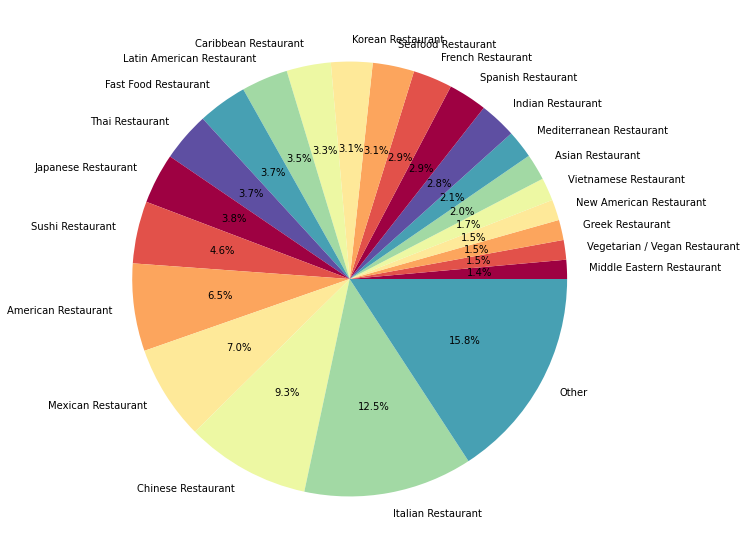

In [66]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
%matplotlib inline

pie_counts = venues_nyc_restaurants.groupby('Venue Category').agg('count')
pie_counts.head()
pct_value = pie_counts[lambda df: df.columns[0]].quantile(.75)
values_below_pct_value = pie_counts[lambda df: df.columns[0]].loc[lambda s: s < pct_value].index.values
def fix_values(row):
    if row['Venue Category'] in values_below_pct_value:
        row['Venue Category'] = 'Other'
    return row 
pie_grouped = venues_nyc_restaurants.apply(fix_values, axis=1).groupby('Venue Category').agg('count')

plt.figure(1, figsize=(20,10))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.subplot(aspect=1)
plt.pie(pie_grouped.Venue.sort_values(), labels=pie_grouped.Venue.sort_values().index, autopct='%1.1f%%', shadow=False, colors=colors)

plt

<AxesSubplot:label='5a0b07b1-8eb3-4a14-a482-3174757e887d', xlabel='Venue Category', ylabel='Pct'>

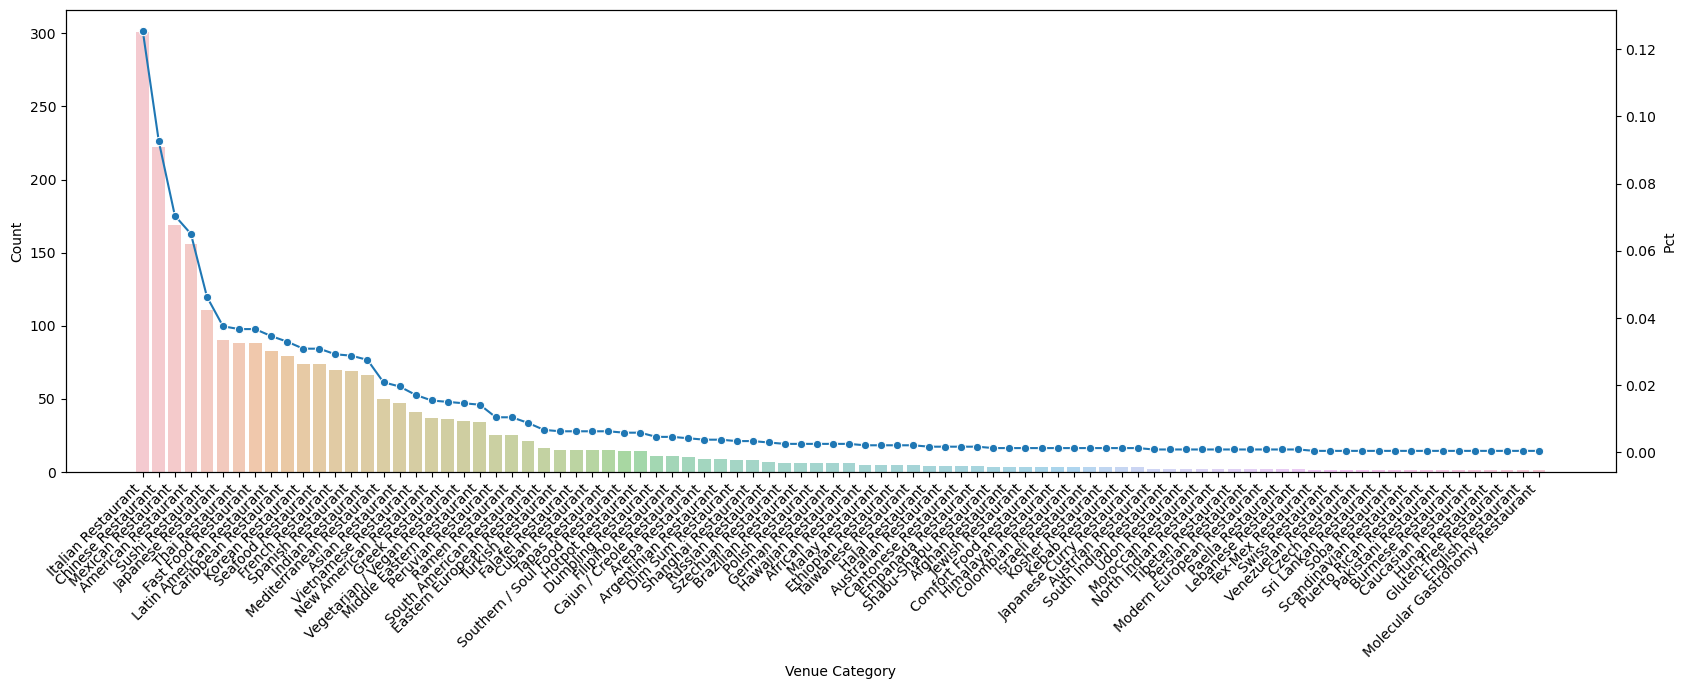

In [67]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(20,6))

h=sns.barplot(data = restaurant_group_nyc, x='Venue Category', y='Count', alpha=0.5, ax=ax1)
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
ax2 = ax1.twinx()
h=sns.lineplot(data = restaurant_group_nyc, x='Venue Category', y='Pct', sort=False, marker='o', ax=ax2)

h

##### summary and visulize restaurants in Toronto

In [13]:
# group by restaurant in Toronto
restaurant_group_toronto=venues_toronto_restaurants.groupby(['Venue Category']).agg({'Venue':'count'}).reset_index()
restaurant_group_toronto.rename(columns={'Venue':'Count'}, inplace=True)
restaurant_group_toronto['Pct']=restaurant_group_toronto['Count']/sum(restaurant_group_toronto['Count'])
restaurant_group_toronto['Pct2'] = pd.Series(["{0:.2f}%".format(val * 100) for val in restaurant_group_toronto['Pct']], index = restaurant_group_toronto.index)
restaurant_group_toronto=restaurant_group_toronto.sort_values(by=['Count'],ascending=False)
restaurant_group_toronto.head(10)

,Venue Category,Count,Pct,Pct2
20,Italian Restaurant,39,0.114035,11.40%
21,Japanese Restaurant,34,0.099415,9.94%
34,Sushi Restaurant,28,0.081871,8.19%
33,Seafood Restaurant,25,0.073099,7.31%
0,American Restaurant,23,0.067251,6.73%
36,Thai Restaurant,18,0.052632,5.26%
17,Greek Restaurant,15,0.043860,4.39%
1,Asian Restaurant,15,0.043860,4.39%
39,Vegetarian / Vegan Restaurant,14,0.040936,4.09%
14,Fast Food Restaurant,14,0.040936,4.09%


<module 'matplotlib.pyplot' from '/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/matplotlib/pyplot.py'>

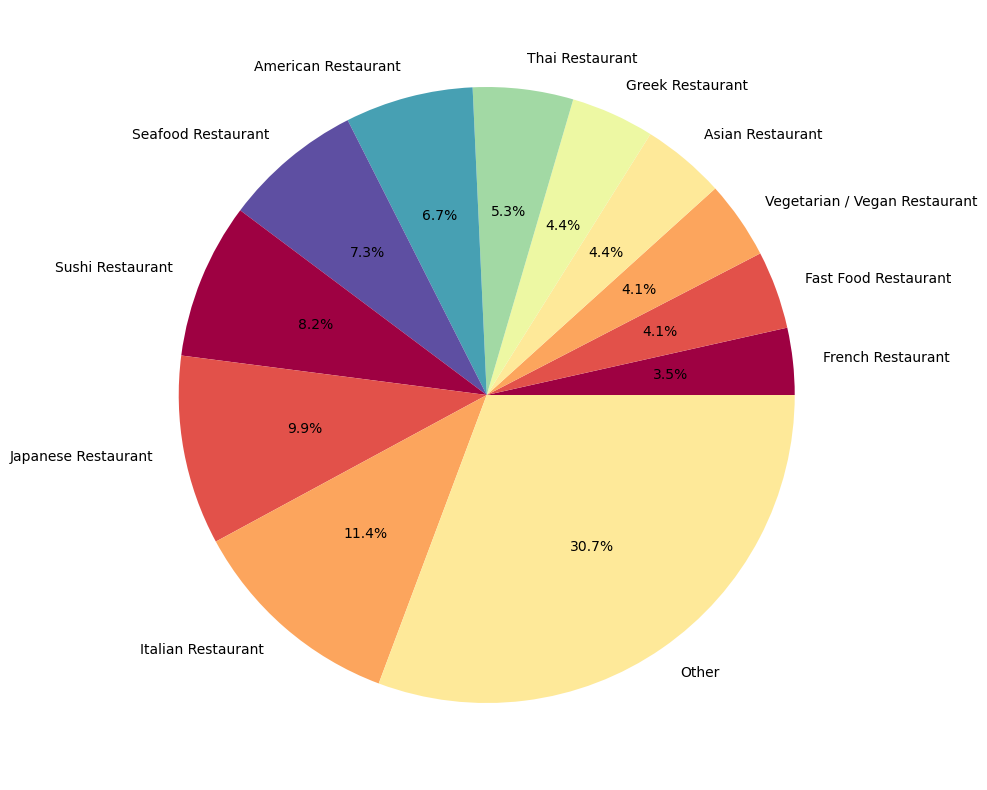

In [68]:
pie_counts = venues_toronto_restaurants.groupby('Venue Category').agg('count')
pie_counts.head()
pct_value = pie_counts[lambda df: df.columns[0]].quantile(.75)
values_below_pct_value = pie_counts[lambda df: df.columns[0]].loc[lambda s: s < pct_value].index.values
def fix_values(row):
    if row['Venue Category'] in values_below_pct_value:
        row['Venue Category'] = 'Other'
    return row 
pie_grouped = venues_toronto_restaurants.apply(fix_values, axis=1).groupby('Venue Category').agg('count')

plt.figure(1, figsize=(20,10))
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.subplot(aspect=1)
plt.pie(pie_grouped.Venue.sort_values(), labels=pie_grouped.Venue.sort_values().index, autopct='%1.1f%%', shadow=False, colors=colors)

plt

<AxesSubplot:label='bb0f5f9f-655a-47fa-802c-ec0c9ef1b888', xlabel='Venue Category', ylabel='Pct'>

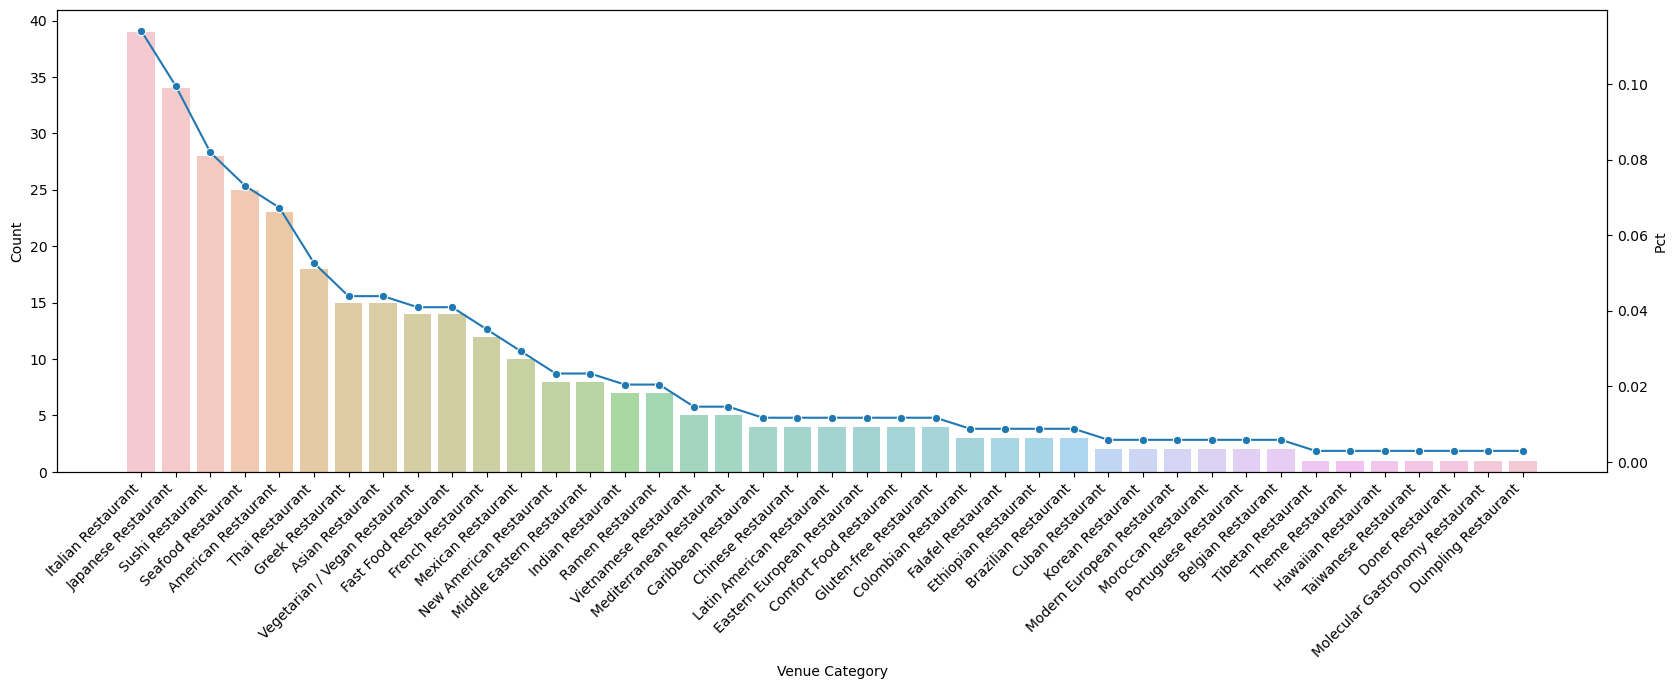

In [69]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(20,6))

h=sns.barplot(data = restaurant_group_toronto, x='Venue Category', y='Count', alpha=0.5, ax=ax1)
h.set_xticklabels(h.get_xticklabels(), rotation=45, horizontalalignment='right')
ax2 = ax1.twinx()
h=sns.lineplot(data = restaurant_group_toronto, x='Venue Category', y='Pct', sort=False, marker='o', ax=ax2)

h

#### Cluster by number of restaurants in each kind

In [25]:
# one hot encoding
nyc_onehot = pd.get_dummies(venues_nyc_restaurants[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = venues_nyc_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns =  list(nyc_onehot[nyc_onehot.columns[~nyc_onehot.columns.isin(['Neighborhood'])]].columns)
fixed_columns.insert(0,'Neighborhood')
nyc_onehot = nyc_onehot[fixed_columns]
nyc_onehot.head()


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Puerto Rican Restaurant,Ramen Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Eastchester,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Eastchester,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Eastchester,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()


,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hotpot Restaurant,Hunan Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Polish Restaurant,Puerto Rican Restaurant,Ramen Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Allerton,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,Annadale,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.400000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.200000,0.000000,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,Arverne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,Astoria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028571,0.0,0.028571,0.0,0.0,0.0,0.028571,0.0,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.0,0.0,0.0,0.0,0.085714,0.0,0.057143,0.0,0.028571,0.0,0.0,0.028571,0.0,0.028571,0.0,0.0,0.114286,0.028571,0.171429,0.0,0.0,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [28]:
num_top_venues = 5

for hood in nyc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                     venue  freq
0      American Restaurant   0.5
1     Fast Food Restaurant   0.5
2        Afghan Restaurant   0.0
3  North Indian Restaurant   0.0
4       Russian Restaurant   0.0


----Annadale----
                     venue  freq
0      American Restaurant   0.5
1         Sushi Restaurant   0.5
2        Afghan Restaurant   0.0
3  North Indian Restaurant   0.0
4       Russian Restaurant   0.0


----Arrochar----
                       venue  freq
0         Italian Restaurant   0.4
1   Mediterranean Restaurant   0.2
2  Middle Eastern Restaurant   0.2
3          Polish Restaurant   0.2
4          Afghan Restaurant   0.0


----Arverne----
                     venue  freq
0          Thai Restaurant   1.0
1        Afghan Restaurant   0.0
2  New American Restaurant   0.0
3         Ramen Restaurant   0.0
4  Puerto Rican Restaurant   0.0


----Astoria----
                       venue  freq
0  Middle Eastern Restaurant  0.17
1         Seafood Restaurant  0.11


##### A function to sort the venues in descending order

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

##### Create the new dataframe and display the top 10 venues for each neighborhood

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,American Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Halal Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
1,Annadale,Sushi Restaurant,American Restaurant,Vietnamese Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
2,Arrochar,Italian Restaurant,Polish Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
3,Arverne,Thai Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
4,Astoria,Middle Eastern Restaurant,Seafood Restaurant,Mediterranean Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Sushi Restaurant,Comfort Food Restaurant,Mexican Restaurant,Chinese Restaurant


##### Run K-means to cluster neighborhoods, k=5

In [34]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 2, 0, 2, 2, 1, 0, 2, 2, 2], dtype=int32)

In [70]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = neighborhoods_nyc

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
nyc_merged = nyc_merged[nyc_merged['Cluster Labels'].notna()]
nyc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,3.0,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
1,Bronx,Co-op City,40.874294,-73.829939,4.0,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
2,Bronx,Eastchester,40.887556,-73.827806,3.0,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
5,Bronx,Kingsbridge,40.881687,-73.902818,2.0,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Falafel Restaurant
6,Manhattan,Marble Hill,40.876551,-73.910660,2.0,Seafood Restaurant,American Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant


In [55]:
# create map
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

##### cluster 1

In [56]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
# cluster 1 looks like Italian restaurant cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Woodlawn,Italian Restaurant,Indian Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
11,Pelham Parkway,Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Vietnamese Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
34,Belmont,Italian Restaurant,Spanish Restaurant,Mexican Restaurant,Eastern European Restaurant,American Restaurant,Japanese Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Ethiopian Restaurant,Falafel Restaurant
39,Edgewater Park,Italian Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
50,Gravesend,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
66,Carroll Gardens,Italian Restaurant,Thai Restaurant,French Restaurant,American Restaurant,Dumpling Restaurant,Japanese Restaurant,Latin American Restaurant,Filipino Restaurant,Sushi Restaurant,Spanish Restaurant
152,Auburndale,Italian Restaurant,American Restaurant,Fast Food Restaurant,Sushi Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant
197,St. George,Italian Restaurant,American Restaurant,Tapas Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
206,Mariner's Harbor,Italian Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
217,Tottenville,Italian Restaurant,Mexican Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant


##### cluster 2

In [57]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
# cluster 2 looks like Chinese restaurants cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Norwood,Chinese Restaurant,Caribbean Restaurant,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Spanish Restaurant,Vietnamese Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
13,Bedford Park,Chinese Restaurant,Mexican Restaurant,Italian Restaurant,Spanish Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant
18,West Farms,Chinese Restaurant,Cuban Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
20,Melrose,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
26,Soundview,Chinese Restaurant,Latin American Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
47,Bensonhurst,Italian Restaurant,Chinese Restaurant,Sushi Restaurant,Shabu-Shabu Restaurant,Hotpot Restaurant,Gluten-free Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
56,East Flatbush,Chinese Restaurant,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
60,Brownsville,Chinese Restaurant,Spanish Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
72,East New York,Chinese Restaurant,Fast Food Restaurant,Asian Restaurant,Spanish Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
73,Starrett City,American Restaurant,Chinese Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Halal Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant


##### cluster 3

In [71]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
# cluster 3 looks like a diversified cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Kingsbridge,Latin American Restaurant,Mexican Restaurant,Spanish Restaurant,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Falafel Restaurant
6,Marble Hill,Seafood Restaurant,American Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
10,Baychester,Fast Food Restaurant,Mexican Restaurant,Spanish Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
12,City Island,Seafood Restaurant,American Restaurant,Italian Restaurant,French Restaurant,Spanish Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant
14,University Heights,African Restaurant,Latin American Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
15,Morris Heights,Spanish Restaurant,Vietnamese Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
16,Fordham,Spanish Restaurant,Chinese Restaurant,Fast Food Restaurant,Latin American Restaurant,African Restaurant,American Restaurant,Mexican Restaurant,Greek Restaurant,Caribbean Restaurant,Vietnamese Restaurant
17,East Tremont,Puerto Rican Restaurant,Vietnamese Restaurant,Jewish Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
19,High Bridge,Latin American Restaurant,Seafood Restaurant,Spanish Restaurant,Italian Restaurant,Asian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
21,Mott Haven,Spanish Restaurant,Peruvian Restaurant,Latin American Restaurant,Chinese Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant


##### cluster 4

In [59]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
# cluster 4 looks like a Caribbean restaurants cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
2,Eastchester,Caribbean Restaurant,Seafood Restaurant,Fast Food Restaurant,Chinese Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
9,Williamsbridge,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
41,Olinville,Caribbean Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
75,Flatlands,Fast Food Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
78,Coney Island,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
164,South Jamaica,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant
165,St. Albans,Caribbean Restaurant,Fast Food Restaurant,Chinese Restaurant,Southern / Soul Food Restaurant,Vietnamese Restaurant,Gluten-free Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
168,Cambria Heights,Caribbean Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
188,Laurelton,Caribbean Restaurant,Vietnamese Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant


##### cluster 5

In [61]:
nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[[1] + list(range(5, nyc_merged.shape[1]))]]
# cluster 5 looks like a fast food cluster

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Co-op City,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
23,Longwood,Latin American Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Greek Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
25,Morrisania,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
80,Borough Park,Fast Food Restaurant,Kosher Restaurant,American Restaurant,Chinese Restaurant,Vietnamese Restaurant,Greek Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant
148,South Ozone Park,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
166,Rochdale,Southern / Soul Food Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
222,Wingate,Vietnamese Restaurant,Fast Food Restaurant,Venezuelan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
237,Pleasant Plains,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant
269,Mount Eden,Fast Food Restaurant,Spanish Restaurant,Vietnamese Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant
288,Roxbury,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant



##### e. Get number of tips/comments, number of photos in each venue

In [32]:
def getVenuesInfo(city):
    for i in range(len(city)):
        venue_id=city.loc[i,'ID']
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
        results = requests.get(url).json()
        #try:
        
        #except:
              #city.loc[i,'Rating']=0
        #try:
        city.loc[i,'# of Tips']=results['response']['venue']['tips']['count']
        #except:
            #city.loc[i,'# of Tips']=0
        #try:
        city.loc[i,'# of Photos']=results['response']['venue']['photos']['count']
        #except:
            #city.loc[i,'# of Photos']=0
        city.loc[i,'Rating']=results['response']['venue']['rating']
    return(city)

In [33]:
Venues_info_Toronto=getVenuesInfo(city=venues_toronto_restaurants)
print(Venues_info_Toronto.shape)
Venues_info_Toronto.head(20)

KeyError: 'venue'

In [14]:
venue_id='3fd66200f964a520f4e41ee3'
#for venue_id in venues_toronto_restaurants['ID']:       
url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
results = requests.get(url).json()
print(venue_id)
try:
    print(results['response']['venue']['rating'])
except:
    print('This venue has not been rated yet.')
print(results['response']['venue']['tips']['count'])
print(results['response']['venue']['photos']['count'])


3fd66200f964a520f4e41ee3
7.3
19
28


In [34]:
test=venues_toronto_restaurants.head(10)
test

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,ID,Rating,# of Tips,# of Photos
0,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Sukhothai,43.658444,-79.365681,Thai Restaurant,4ada57aff964a520972121e3,0.0,0.0,0.0
1,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Impact Kitchen,43.656369,-79.356980,Restaurant,5612b1cc498e3dd742af0dc8,0.0,0.0,0.0
2,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,Mangia and Bevi Resto-Bar,43.652250,-79.366355,Italian Restaurant,4ad776eef964a520e20a21e3,0.0,0.0,0.0
3,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Tokyo Sushi,43.665885,-79.386977,Sushi Restaurant,4afca145f964a5208e2422e3,0.0,0.0,0.0
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Como En Casa,43.665160,-79.384796,Mexican Restaurant,4fb593c0e4b05a76e2ab2951,0.0,0.0,0.0
5,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Nando's,43.661728,-79.386391,Portuguese Restaurant,52d884c5498ecf5c7cafe5ab,0.0,0.0,0.0
6,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Sansotei Ramen 三草亭,43.666735,-79.385353,Ramen Restaurant,534c20fa498ee7bc010834ce,0.0,0.0,0.0
7,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Sushi Garden,43.664858,-79.384941,Sushi Restaurant,4ba6b463f964a520416a39e3,0.0,0.0,0.0
8,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Tokyo Grill,43.665085,-79.384707,Japanese Restaurant,4ad4c061f964a520abf720e3,0.0,0.0,0.0
9,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,Ethiopian House,43.666599,-79.385669,Ethiopian Restaurant,4a72360ef964a52098da1fe3,0.0,0.0,0.0


In [35]:
for i in range(len(test)):
    venue_id=test.loc[i,'ID']
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
    results = requests.get(url).json()
    #try:
    test.loc[i,'Rating']=results['response']['venue']['rating']
    #except:
    #test.loc[i,'Rating']=0
    test.loc[i,'# of Tips']=results['response']['venue']['tips']['count']
    test.loc[i,'# of Photos']=results['response']['venue']['photos']['count']
test

KeyError: 'venue'

In [36]:
results

{'meta': {'code': 403,
  'errorType': 'rate_limit_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '5ffe842e9fc7d574b2513bc1'},
 'response': {}}